In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

warnings.filterwarnings('ignore')

Loading dataset...
Dataset basic information:
Data shape: (422448, 7)
Facility type distribution:
facility_type
Tennis        158254
Basketball    152164
Badminton      72108
Squash         39922
Name: count, dtype: int64
Booking success rate: 66.54%

Performing feature engineering...
Feature engineering completed!
Number of features after processing: 18
Training set size: (337958, 15)
Test set size: (84490, 15)

Training Logistic Regression...
Logistic Regression accuracy: 0.7448

Training Random Forest...
Random Forest accuracy: 0.7942

Best model: Random Forest
Classification report:
              precision    recall  f1-score   support

       False       0.72      0.63      0.67     28273
        True       0.82      0.88      0.85     56217

    accuracy                           0.79     84490
   macro avg       0.77      0.75      0.76     84490
weighted avg       0.79      0.79      0.79     84490



<Figure size 1000x800 with 0 Axes>

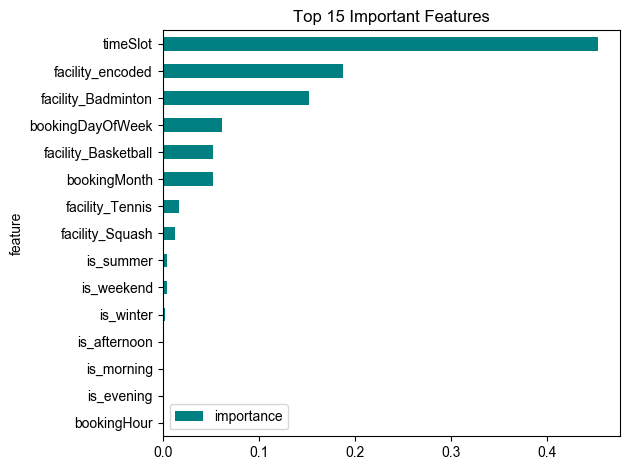


=== Business Insights and Recommendations ===
Easiest facility to book: Basketball (success rate: 79.69%)
Best booking time: 16:00 (success rate: 66.54%)
Weekday success rate: 67.21%
Weekend success rate: 64.86%

=== Prediction Examples ===
Tennis - Sat 18:00 - Booking success probability: 78.27%
Badminton - Wed 10:00 - Booking success probability: 38.75%
Basketball - Sun 20:00 - Booking success probability: 95.48%

Project completed! You can provide data-driven suggestions for school facility management based on this analysis.


In [2]:
# 1. Load data from CSV file
print("Loading dataset...")
df = pd.read_csv('../data/machinelearning.csv')

print("Dataset basic information:")
print(f"Data shape: {df.shape}")
print(f"Facility type distribution:\n{df['facility_type'].value_counts()}")
print(f"Booking success rate: {df['can_use'].mean():.2%}")

# 2. Feature engineering
print("\nPerforming feature engineering...")
df_processed = df.copy()

# Time period features
df_processed['is_weekend'] = (df_processed['bookingDayOfWeek'] >= 5).astype(int)
df_processed['is_evening'] = ((df_processed['bookingHour'] >= 18) & (df_processed['bookingHour'] <= 22)).astype(int)
df_processed['is_morning'] = ((df_processed['bookingHour'] >= 7) & (df_processed['bookingHour'] <= 12)).astype(int)
df_processed['is_afternoon'] = ((df_processed['bookingHour'] >= 13) & (df_processed['bookingHour'] <= 17)).astype(int)

# Seasonal features
df_processed['is_summer'] = df_processed['bookingMonth'].isin([6, 7, 8]).astype(int)
df_processed['is_winter'] = df_processed['bookingMonth'].isin([12, 1, 2]).astype(int)

# Facility type encoding
le = LabelEncoder()
df_processed['facility_encoded'] = le.fit_transform(df_processed['facility_type'])

# Create one-hot encoding for facility types
facility_dummies = pd.get_dummies(df_processed['facility_type'], prefix='facility')
df_processed = pd.concat([df_processed, facility_dummies], axis=1)

print("Feature engineering completed!")
print(f"Number of features after processing: {df_processed.shape[1]}")

# 3. Model training
# Prepare features and target variable
feature_columns = [
    'timeSlot', 'bookingHour', 'bookingDayOfWeek', 'bookingMonth',
    'is_weekend', 'is_evening', 'is_morning', 'is_afternoon',
    'is_summer', 'is_winter', 'facility_encoded'
] + list(facility_dummies.columns)

X = df_processed[feature_columns]
y = df_processed['can_use']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train multiple models for comparison
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    print(f"{name} accuracy: {accuracy:.4f}")

# 4. Model evaluation and interpretation
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name}")
print("Classification report:")
print(classification_report(y_test, results[best_model_name]['predictions']))

# Feature importance analysis (if it's Random Forest)
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 8))
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    feature_importance.tail(15).plot(kind='barh', x='feature', y='importance', color='teal')
    plt.title('Top 15 Important Features')
    plt.tight_layout()
    plt.show()

# 5. Business insights and recommendations
print("\n=== Business Insights and Recommendations ===")

# Analyze best booking strategy
facility_success = df_processed.groupby('facility_type')['can_use'].mean()
best_facility = facility_success.idxmax()
print(f"Easiest facility to book: {best_facility} (success rate: {facility_success[best_facility]:.2%})")

# Analyze best time slot
hour_success = df_processed.groupby('bookingHour')['can_use'].mean()
best_hour = hour_success.idxmax()
print(f"Best booking time: {best_hour}:00 (success rate: {hour_success[best_hour]:.2%})")

# Analyze weekend vs weekday
weekend_success = df_processed.groupby('is_weekend')['can_use'].mean()
print(f"Weekday success rate: {weekend_success[0]:.2%}")
print(f"Weekend success rate: {weekend_success[1]:.2%}")

# 6. Create prediction function (utility tool)
def predict_booking_success(facility, hour, day_of_week, month, time_slot):
    """Predict booking success probability under specific conditions"""
    # Create input data
    input_data = {
        'timeSlot': time_slot,
        'bookingHour': hour,
        'bookingDayOfWeek': day_of_week,
        'bookingMonth': month,
        'is_weekend': 1 if day_of_week >= 5 else 0,
        'is_evening': 1 if 18 <= hour <= 22 else 0,
        'is_morning': 1 if 7 <= hour <= 12 else 0,
        'is_afternoon': 1 if 13 <= hour <= 17 else 0,
        'is_summer': 1 if month in [6, 7, 8] else 0,
        'is_winter': 1 if month in [12, 1, 2] else 0,
        'facility_encoded': le.transform([facility])[0]
    }
    
    # Add facility one-hot encoding
    for facility_type in facility_dummies.columns:
        input_data[facility_type] = 1 if facility_type == f"facility_{facility}" else 0
    
    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])[feature_columns]
    
    # Predict probability
    probability = best_model.predict_proba(input_df)[0][1]
    
    return probability

# Test prediction function
print("\n=== Prediction Examples ===")
test_cases = [
    ('Tennis', 18, 5, 6, 15),  # Saturday 6 PM tennis
    ('Badminton', 10, 2, 3, 8),  # Tuesday 10 AM badminton
    ('Basketball', 20, 6, 12, 18)  # Sunday 8 PM basketball
]

for facility, hour, day, month, time_slot in test_cases:
    prob = predict_booking_success(facility, hour, day, month, time_slot)
    print(f"{facility} - {['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][day]} {hour}:00 - Booking success probability: {prob:.2%}")

print("\nProject completed! You can provide data-driven suggestions for school facility management based on this analysis.")